<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


# Лемматизируем текст

Создадим корпус слов

In [5]:
corpus = list(data['text'])

Загружаем словари:

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
def clear_text(text):
    y=re.sub(r"[^'a-zA-Z ]", ' ', text) 
    k=" ".join(y.split())
    return k

In [10]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
%%time
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

lemy=[]
for i in tqdm(range(len(corpus))):
    
    lemy.append(lemmafunction(clear_text(corpus[i])))
data['lemm_text']=pd.Series(lemy, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 22min 36s, sys: 2min 7s, total: 24min 44s
Wall time: 25min 27s


Проверка результата:

In [12]:
data['text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [13]:
data['lemm_text'][3]

"More I ca n't make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know There appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It 's list in the relevant form eg Wikipedia Good article nomination Transport"

Посмотрим на баланс распределения классов в данных:

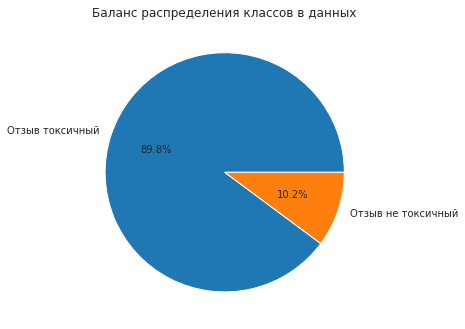

In [14]:
sns.set_style('darkgrid')
data['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',labels=['Отзыв токсичный','Отзыв не токсичный'])
plt.title('Баланс распределения классов в данных')

plt.ylabel('')
plt.show()

Разделим датасет на выборки:

In [15]:
X=data.drop('toxic',axis=1)
y=data['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, shuffle=True, stratify=y)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(119469, 2) (39823, 2) (119469,) (39823,)


Загрузим библиотеку и стоп-слова из английского языка

In [16]:
nltk.download('stopwords') 
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим корпус из лемматизированных и очищенных слов:

In [17]:
corpus_lemm_train = X_train['lemm_text'].values.astype('U')
corpus_lemm_train.shape

(119469,)

Применим модель TfidfVectorizer и обучим на тренировочных данных:

In [18]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words,analyzer='word') 
tf_idf = count_tf_idf.fit_transform(corpus_lemm_train) 
tf_idf.shape

(119469, 134623)

Создадим корпус слов для тестовой выборки:

In [19]:
corpus_lemm_test = X_test['lemm_text'].values.astype('U')
corpus_lemm_test.shape

(39823,)

Трансформируем тестовую выборку:

In [20]:
tf_test = count_tf_idf.transform(corpus_lemm_test)
tf_test.shape

(39823, 134623)

Когда мы используем TF-IDF -  это может помочь уменьшить влияние стоп-слов на векторы и повысить производительность модели. 

## Обучение

In [21]:
test_score = {}

Произведем обученине моделей. Для подбора параметров используем инструмент GridSearchCV.

1.LogisticRegression

In [22]:
%%time
lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100)
params = {
   'penalty':['l1', 'l2'],        
   'C':list(range(1,15,3)) 
}

lr_gs = GridSearchCV(lr, params, cv=3, scoring='f1', verbose=True).fit(tf_idf,y_train)

print(f'Лучшая RMSE: {lr_gs.best_score_} при параметрах {lr_gs.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшая RMSE: 0.7687105782548541 при параметрах {'C': 4, 'penalty': 'l1'}
CPU times: user 1min 53s, sys: 1min 22s, total: 3min 15s
Wall time: 3min 16s


In [23]:
test_score['LogisticRegression'] = [lr_gs.best_score_]

2.RandomForestClassifier

In [24]:
%%time

forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1 )

params = { 'n_estimators': range(20, 40, 5),
                     'max_depth': range(4, 8, 2),
                     'min_samples_leaf': range(3,5),
                     'min_samples_split': range(2,6,2)}

forest_grid = GridSearchCV(forest, params, scoring='f1', cv=3)
rforest_model=forest_grid.fit(tf_idf,y_train)
print(f'Лучшая RMSE: {rforest_model.best_score_} при параметрах ,{rforest_model.best_params_}')

Лучшая RMSE: 0.3792085787000073 при параметрах ,{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 25}
CPU times: user 4min 44s, sys: 3.2 s, total: 4min 47s
Wall time: 4min 49s


In [25]:
test_score['RandomForestClassifier'] = [rforest_model.best_score_]

3.DecisionTreeClassifier

In [26]:
%%time
tree = DecisionTreeClassifier(random_state = 12345)
params = {
   'criterion':['gini', 'entropy'],        
   'max_depth':list(range(1,15,5)) 
}

tree_gs = GridSearchCV(tree, params, cv=3, scoring='f1', verbose=True).fit(tf_idf,y_train)
print(f'Лучшая RMSE: {tree_gs.best_score_} при параметрах ,{tree_gs.best_params_}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Лучшая RMSE: 0.6033515614118744 при параметрах ,{'criterion': 'gini', 'max_depth': 11}
CPU times: user 3min 12s, sys: 705 ms, total: 3min 13s
Wall time: 3min 14s


In [27]:
test_score['DecisionTreeClassifier'] = [tree_gs.best_score_]

Сравниваем модели:

In [28]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['f1'], orient='index')
df_score

,f1
LogisticRegression,0.768711
RandomForestClassifier,0.379209
DecisionTreeClassifier,0.603352


Проверим LogisticRegression на тестовой выборке, у нее лучше значение метрики:

In [29]:
pred1 = lr_gs.best_estimator_.predict(tf_test)      
f1_lr = f1_score(y_test, pred1)     
f1_lr

0.7823632208630192

## Выводы

На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159292 строк.

Затем тексты комментариев были очищены и лемматизированы. 

В качестве моделей использованы LogisticRegression, RandomForestClassifier, DecisionTreeClassifier. 

По результатам подбора гиперпараметров и обучения моделей наилучший результат показал LogisticRegression, наихудший - RandomForestClassifier. 

Пороговое значение метрики 0.75 преодолено, получено 0.77. 

Лучшая модель - логистическая регрессия с подробранными гиперпараметрами C = 4, penalty = 'l1'.

Модель LogisticRegression подходит для решения поставленной задачи.   